In [1]:
import torch
import torchvision
import torchvision.models as models
from torchvision import datasets, models, transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
from google.colab import drive
drive.mount("./gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [4]:
DATADIR = './gdrive/My Drive/DeepLearning/covid19'

In [5]:
batch_size = 8
Datatransforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                     ])

mtransforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.517, 0.517, 0.517],
                                                            [0.21, 0.21, 0.21])])

#pass transform here-in
train_data = datasets.ImageFolder(DATADIR + '/train', transform=Datatransforms)
test_data = datasets.ImageFolder(DATADIR + '/test', transform=Datatransforms)
# validation_data = datasets.ImageFolder(DATADIR + '/Validation', transform=Datatransforms)


#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)
# validationloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['COVID19', 'NORMAL', 'PNEUMONIA']


In [17]:
test_data

Dataset ImageFolder
    Number of datapoints: 1288
    Root location: ./gdrive/My Drive/DeepLearning/covid19/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [19]:
train = [228, 4400, 2196]
test = [116, 317, 855]


[Text(0, 0, 'COVID19'), Text(0, 0, 'NORMAL'), Text(0, 0, 'PNEUMONIA')]

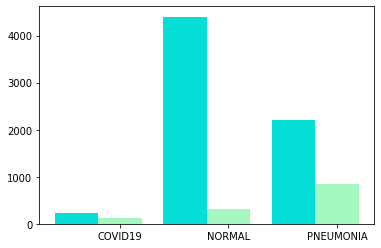

In [26]:
x = np.array([1,2,3])
w = 0.4
ax = plt.subplot(111)
ax.bar(x, train, width=w, color='#05dfd7', align='center')
ax.bar(x+w, test, width=w, color='#a3f7bf', align='center')

ax.set_xticks(x+w)
ax.set_xticklabels( class_names )

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

In [7]:
inputs, classes = next(iter(trainloader))
inputs.shape, classes.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


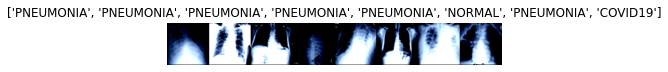

In [8]:
show_databatch(inputs, classes)

In [9]:
def one_hot_encoding(labels):
    labels = labels.to(device)
    labels = labels.reshape(labels.size()[0], 1)
    one_hot =  (labels == torch.arange(3, device=device))
    
    one_hot[:, 2] = one_hot[:, 0]+one_hot[:, 2]
    return one_hot

In [10]:
one_hot_encoding(classes)

tensor([[False, False,  True],
        [False, False,  True],
        [False, False,  True],
        [False, False,  True],
        [False, False,  True],
        [False,  True, False],
        [False, False,  True],
        [ True, False,  True]], device='cuda:0')

In [11]:
def printConfusion_Matrix(c , classes_info , title):
  plt.pause(0.01)
  plt.figure()
  ax= plt.subplot()
  sns.heatmap(c, annot=True, ax = ax  ,cmap='Greens' ,fmt='g');

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title(title); 
  ax.xaxis.set_ticklabels(classes_info); ax.yaxis.set_ticklabels(classes_info);



def print_confusion_matrix(true_labels, predicted_labels):
    conf_mat_multilabel = multilabel_confusion_matrix(true_labels, predicted_labels) 
    printConfusion_Matrix(conf_mat_multilabel[class_names.index("COVID19")] , ['-ive','+ive'] , '0-index Label (Covid -19)' )
    printConfusion_Matrix(conf_mat_multilabel[class_names.index("NORMAL")] , ['-ive','+ive'] ,    '1-index Label (Normal)')
    printConfusion_Matrix(conf_mat_multilabel[class_names.index("PNEUMONIA")] , ['-ive','+ive']  , '2-index Label (Pneumonia)')
  

In [12]:
class floss(nn.Module):
    def __init__(self, alpha=1, gamma=1.2):
        super(floss,self).__init__()
        self.a = alpha
        self.g = gamma
        
    def forward(self, outputs, labels):
        bce = F.binary_cross_entropy_with_logits(outputs, labels)
        pt = torch.exp(-bce)
        loss = self.a * ((1-pt)**self.g) * bce
        return loss.mean()

In [13]:
def fit(model, train_dataloader, criterion, optimizer):
    model.to(device)
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    
    for i, data in enumerate(train_dataloader):
        
        data, target = data[0].to(device), data[1].to(device)
        labels = one_hot_encoding(target).float()
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
 
    
    return train_loss, train_accuracy

In [14]:
def train(model, critarion, optimizer, trainloader,  epochs = 10):

    train_loss , train_accuracy = [], []
    val_loss , val_accuracy = [], []
    start = time.time()
    for epoch in range(epochs):
        train_epoch_loss, train_epoch_accuracy = fit(model, trainloader, critarion, optimizer)
        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)
        print('Epoch: ', epoch)
        print(f'Train Loss: {train_epoch_loss}, Train Acc: {train_epoch_accuracy}')
        
        print('==========================================================================')
    end = time.time()

    print('Running Time: ',(end-start)/60, 'minutes')

    return train_loss , train_accuracy

In [15]:
def test(model, test_dataloader, criterion):
    model.to(device)
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    test_predicted = list()
    test_true_labels = list()
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        
        labels = one_hot_encoding(target).float()
        labels = labels.to(device)
        output = model(data)
        loss = criterion(output, labels)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()

        test_predicted.extend(list(np.array(preds.cpu())))
        test_true_labels.extend(list(np.array(target.cpu())))

    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    

    return val_loss, val_accuracy, test_predicted, test_true_labels

In [ ]:
vgg16_NL = models.vgg16(pretrained=True)
for param in vgg16_NL.features.parameters():
    param.require_grad = False

num_features = vgg16_NL.classifier[0].in_features

newClassifierLayers = [nn.Linear(num_features, 1024) , nn.ReLU(inplace=True) , nn.Dropout(p =0.5)  ]
newClassifierLayers.extend([nn.Linear(1024, 128)])
newClassifierLayers.extend([nn.Linear(128, len(class_names))])
vgg16_NL.classifier = nn.Sequential(*newClassifierLayers)
vgg16_NL

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model = vgg16_NL
critarion = floss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 20

train_loss , train_accuracy = train(model, critarion, optimizer, trainloader, epochs)
torch.save(model, './gdrive/My Drive/DeepLearning/vgg16_trained_new')
test_loss, test_accuracy, test_predicted, test_true_labels = test(model, testloader, critarion)

print(f'Test Loss: {test_loss}, Test Acc: {test_accuracy}')

Epoch:  0
Train Loss: 0.00574666131549125, Train Acc: 86.1664712778429
Epoch:  1
Train Loss: 0.002624027352046162, Train Acc: 90.2989449003517
Epoch:  2
Train Loss: 0.002479117502192286, Train Acc: 90.82649472450176
Epoch:  3
Train Loss: 0.0015951941151547357, Train Acc: 92.20398593200468
Epoch:  4
Train Loss: 0.0011606228275766323, Train Acc: 92.86342321219226
Epoch:  5
Train Loss: 0.0008883655485878374, Train Acc: 93.8599062133646
Epoch:  6
Train Loss: 0.00058956063166141, Train Acc: 94.5926143024619
Epoch:  7
Train Loss: 0.0005261981286308081, Train Acc: 95.03223915592028
Epoch:  8
Train Loss: 0.0002345599120989211, Train Acc: 95.7356389214537
Epoch:  9
Train Loss: 0.00011997423048288453, Train Acc: 96.29249706916764
Epoch:  10
Train Loss: 7.992589311084889e-05, Train Acc: 96.58558030480657
Epoch:  11
Train Loss: 6.99182173260927e-05, Train Acc: 96.60023446658852
Epoch:  12
Train Loss: 4.459529131716749e-05, Train Acc: 96.73212192262602
Epoch:  13
Train Loss: 2.402969661404164e-05, 

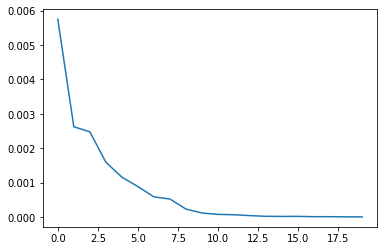

In [ ]:
plt.plot(range(len(train_loss)), train_loss)

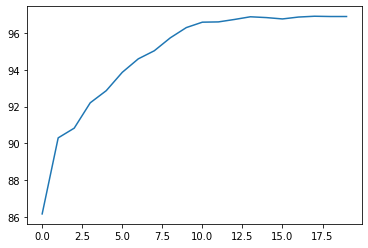

In [ ]:

plt.plot(range(len(train_accuracy)), train_accuracy)

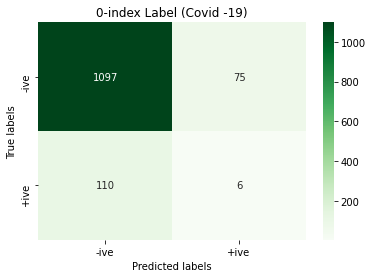

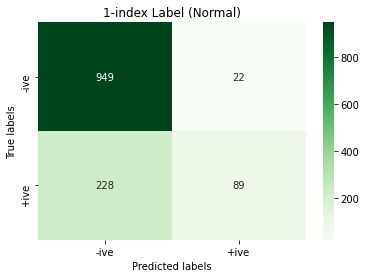

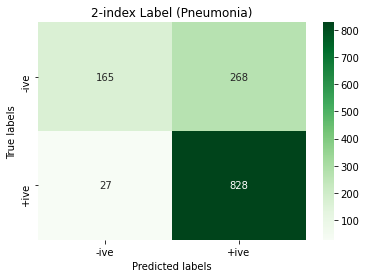

In [ ]:
print_confusion_matrix(test_true_labels, test_predicted)

In [ ]:

print(classification_report(test_true_labels, test_predicted, target_names=class_names))

              precision    recall  f1-score   support

     COVID19       0.07      0.05      0.06       116
      NORMAL       0.80      0.28      0.42       317
   PNEUMONIA       0.76      0.97      0.85       855

    accuracy                           0.72      1288
   macro avg       0.54      0.43      0.44      1288
weighted avg       0.71      0.72      0.67      1288



In [ ]:
resnet18 = models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False
num_features = resnet18.fc.in_features
fc = [
      nn.Linear(num_features, 1024),
      nn.ReLU(),
      nn.Linear(1024, 128),
      nn.ReLU(),
      # nn.Linear(2048, 1024),
      # nn.ReLU(),
      nn.Linear(128, len(train_data.classes))
]
resnet18.fc = nn.Sequential(*fc)
for param in resnet18.fc.parameters():
    param.requires_grad = True
resnet18

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model = resnet18
critarion = floss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 20

train_loss , train_accuracy = train(model, critarion, optimizer, trainloader, epochs)


Epoch:  0
Train Loss: 0.014655726582520496, Train Acc: 73.10961313012896
Epoch:  1
Train Loss: 0.008759026434752928, Train Acc: 82.18053927315357
Epoch:  2
Train Loss: 0.008127144241198113, Train Acc: 82.6934349355217
Epoch:  3
Train Loss: 0.007555991341400857, Train Acc: 83.10375146541618
Epoch:  4
Train Loss: 0.0068163397189479205, Train Acc: 84.24677608440797
Epoch:  5
Train Loss: 0.006893977423903837, Train Acc: 83.54337631887456
Epoch:  6
Train Loss: 0.006762823345886701, Train Acc: 83.76318874560376
Epoch:  7
Train Loss: 0.006467781659246533, Train Acc: 84.14419695193435
Epoch:  8
Train Loss: 0.006393907074075452, Train Acc: 84.42262602579133
Epoch:  9
Train Loss: 0.005667230953523973, Train Acc: 84.95017584994139
Epoch:  10
Train Loss: 0.005958856296306448, Train Acc: 84.21746776084407
Epoch:  11
Train Loss: 0.005741575184818778, Train Acc: 84.83294255568582
Epoch:  12
Train Loss: 0.005349124220088586, Train Acc: 85.55099648300117
Epoch:  13
Train Loss: 0.005899882482003517, Tra

In [ ]:
test_loss, test_accuracy, test_predicted, test_true_labels = test(model, testloader, critarion)

print(f'Test Loss: {test_loss}, Test Acc: {test_accuracy}')

Test Loss: 0.0414764464121335, Test Acc: 45.18633540372671


In [ ]:
torch.save(model, './gdrive/My Drive/DeepLearning/resnet18_trained')

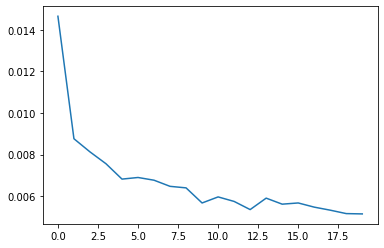

In [ ]:
plt.plot(range(len(train_loss)), train_loss)

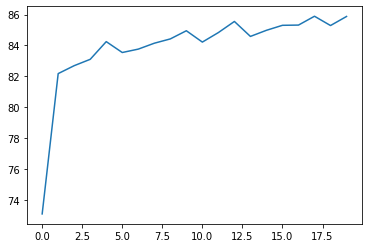

In [ ]:
plt.plot(range(len(train_accuracy)), train_accuracy)

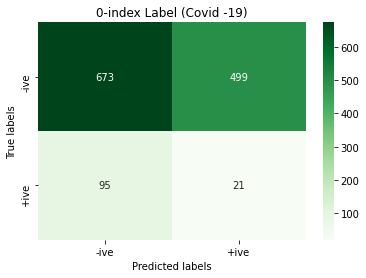

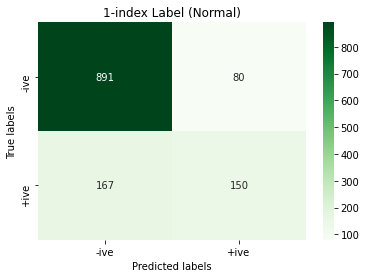

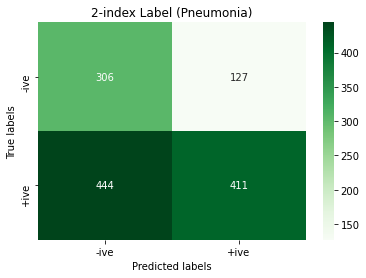

In [ ]:
print_confusion_matrix(test_true_labels, test_predicted)

In [ ]:
print(classification_report(test_true_labels, test_predicted, target_names=class_names))

              precision    recall  f1-score   support

     COVID19       0.04      0.18      0.07       116
      NORMAL       0.65      0.47      0.55       317
   PNEUMONIA       0.76      0.48      0.59       855

    accuracy                           0.45      1288
   macro avg       0.49      0.38      0.40      1288
weighted avg       0.67      0.45      0.53      1288



In [16]:
train_data

Dataset ImageFolder
    Number of datapoints: 6824
    Root location: ./gdrive/My Drive/DeepLearning/covid19/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [17]:
test_data

Dataset ImageFolder
    Number of datapoints: 1288
    Root location: ./gdrive/My Drive/DeepLearning/covid19/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [16]:
vgg16_NL = models.vgg16(pretrained=True)
for param in vgg16_NL.features.parameters():
    param.require_grad = False

num_features = vgg16_NL.classifier[0].in_features

newClassifierLayers = [nn.Linear(num_features, 1024) , nn.ReLU(inplace=True) , nn.Dropout(p =0.5)  ]
newClassifierLayers.extend([nn.Linear(1024, 128)])
newClassifierLayers.extend([nn.Linear(128, len(class_names))])
vgg16_NL.classifier = nn.Sequential(*newClassifierLayers)
vgg16_NL

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
model = vgg16_NL
critarion = floss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 10

train_loss , train_accuracy = train(model, critarion, optimizer, trainloader, epochs)
torch.save(model, './gdrive/My Drive/DeepLearning/vgg16_trained_1')
test_loss, test_accuracy, test_predicted, test_true_labels = test(model, testloader, critarion)

print(f'Test Loss: {test_loss}, Test Acc: {test_accuracy}')

Epoch:  0
Train Loss: 0.005877202639877532, Train Acc: 85.84407971864009
Epoch:  1
Train Loss: 0.0027591668049167166, Train Acc: 90.25498241500586
Epoch:  2
Train Loss: 0.001928205573325888, Train Acc: 91.70574443141852
Epoch:  3
Train Loss: 0.0015331132778108362, Train Acc: 92.58499413833529
Epoch:  4
Train Loss: 0.0014027354916235468, Train Acc: 93.17116060961312
Epoch:  5
Train Loss: 0.0008059196992385967, Train Acc: 93.96248534583822
Epoch:  6
Train Loss: 0.0006102489339528118, Train Acc: 94.62192262602579
Epoch:  7
Train Loss: 0.000414121945183482, Train Acc: 95.04689331770223
Epoch:  8
Train Loss: 0.00023458271221259676, Train Acc: 95.98475967174677
Epoch:  9
Train Loss: 0.00016558133318882786, Train Acc: 96.20457209847596
Running Time:  72.33303281068802 minutes
Test Loss: 0.11869522808871655, Test Acc: 63.975155279503106


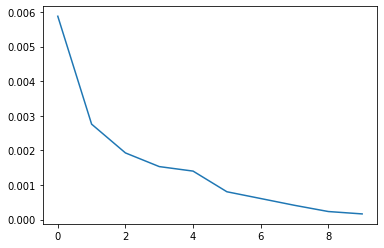

In [18]:

plt.plot(range(len(train_loss)), train_loss)

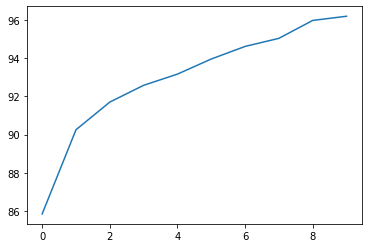

In [19]:
plt.plot(range(len(train_accuracy)), train_accuracy)

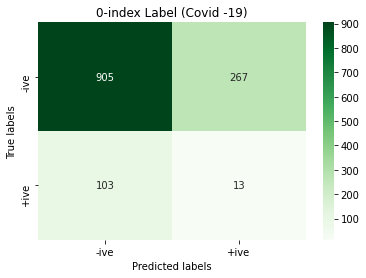

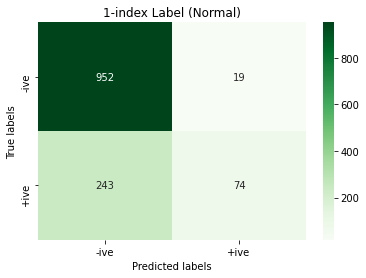

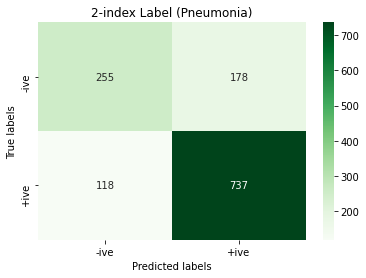

In [20]:
print_confusion_matrix(test_true_labels, test_predicted)

In [21]:
print(classification_report(test_true_labels, test_predicted, target_names=class_names))

              precision    recall  f1-score   support

     COVID19       0.05      0.11      0.07       116
      NORMAL       0.80      0.23      0.36       317
   PNEUMONIA       0.81      0.86      0.83       855

    accuracy                           0.64      1288
   macro avg       0.55      0.40      0.42      1288
weighted avg       0.73      0.64      0.65      1288

